# Task04 数据完整存储与内存的数据集类+节点预测与边预测任务实践

## 1 知识梳理

### 1.1 使用数据集的一般过程
1. 从网络上**下载**数据原始文件；
2. 对数据原始文件做处理，为每一个图样本**生成**一个**`Data`对象**；
3. 对每一个`Data`对象**执行数据处理**，使其转换成新的`Data`对象；
4. **过滤`Data`对象**；
5. **保存`Data`对象到文件**；
6. 获取`Data`对象，在每一次获取`Data`对象时，都先对`Data`对象做数据变换（于是获取到的是数据变换后的`Data`对象）。

### 1.2 边预测任务
- 思路：生成负样本，使得正负样本数量平衡
- 使用`train_test_split_edges`函数，采样得到负样本，并将正负样本分成训练集、验证集和测试集

## 2 实战练习

### 2.1 PlanetoidPubMed数据集类的构造

In [1]:
import os.path as osp

import torch
from torch_geometric.data import (InMemoryDataset, download_url)
from torch_geometric.io import read_planetoid_data


class PlanetoidPubMed(InMemoryDataset):
    r""" 节点代表文章，边代表引文关系。
                 训练、验证和测试的划分通过二进制掩码给出。
    参数:
        root (string): 存储数据集的文件夹的路径
        transform (callable, optional): 数据转换函数，每一次获取数据时被调用。
        pre_transform (callable, optional): 数据转换函数，数据保存到文件前被调用。
    """

    #     url = 'https://github.com/kimiyoung/planetoid/raw/master/data'
    url = 'https://gitee.com/jiajiewu/planetoid/raw/master/data'

    def __init__(self, root, transform=None, pre_transform=None):
        super(PlanetoidPubMed, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_dir(self):
        return osp.join(self.root, 'raw')

    @property
    def processed_dir(self):
        return osp.join(self.root, 'processed')

    @property
    def raw_file_names(self):
        names = ['x', 'tx', 'allx', 'y', 'ty', 'ally', 'graph', 'test.index']
        return ['ind.pubmed.{}'.format(name) for name in names]

    @property
    def processed_file_names(self):
        return 'data.pt'

    def download(self):
        for name in self.raw_file_names:
            download_url('{}/{}'.format(self.url, name), self.raw_dir)

    def process(self):
        data = read_planetoid_data(self.raw_dir, 'pubmed')
        data = data if self.pre_transform is None else self.pre_transform(data)
        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self):
        return '{}()'.format(self.name)

程序运行流程：
1. 检查数据原始文件是否已经下载
2. 检查数据是否经过处理：检查数据变换的方法、检查样本过滤的方法、检查是否处理好数据

In [2]:
dataset = PlanetoidPubMed('dataset/PlanetoidPubMed')
print('数据类别个数:', dataset.num_classes)
print('节点数:', dataset[0].num_nodes)
print('边数:', dataset[0].num_edges)
print('节点特征维度:', dataset[0].num_features)

数据类别个数: 3
节点数: 19717
边数: 88648
节点特征维度: 500


### 2.2 使用GAT图神经网络进行节点预测

In [3]:
from torch_geometric.nn import GATConv, Sequential
from torch.nn import Linear, ReLU
import torch.nn.functional as F

class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels_list, num_classes):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        hns = [num_features] + hidden_channels_list
        conv_list = []
        for idx in range(len(hidden_channels_list)):
            conv_list.append((GATConv(hns[idx], hns[idx+1]), 'x, edge_index -> x'))
            conv_list.append(ReLU(inplace=True),)

        self.convseq = Sequential('x, edge_index', conv_list)
        self.linear = Linear(hidden_channels_list[-1], num_classes)

    def forward(self, x, edge_index):
        x = self.convseq(x, edge_index)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear(x)
        return x

In [4]:
def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    # Compute the loss solely based on the training nodes.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss


def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

In [5]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color.cpu(), cmap="Set2")
    plt.show()

dataset.num_features: 500
GAT(
  (convseq): Sequential(
    (0): GATConv(500, 200, heads=1)
    (1): ReLU(inplace=True)
    (2): GATConv(200, 100, heads=1)
    (3): ReLU(inplace=True)
  )
  (linear): Linear(in_features=100, out_features=3, bias=True)
)
Epoch: 010, Loss: 0.7733
Epoch: 020, Loss: 0.2019
Epoch: 030, Loss: 0.0531
Epoch: 040, Loss: 0.0172
Epoch: 050, Loss: 0.0172
Epoch: 060, Loss: 0.0272
Epoch: 070, Loss: 0.0096
Epoch: 080, Loss: 0.0141
Epoch: 090, Loss: 0.0140
Epoch: 100, Loss: 0.0279
Epoch: 110, Loss: 0.0061
Epoch: 120, Loss: 0.0141
Epoch: 130, Loss: 0.0138
Epoch: 140, Loss: 0.0200
Epoch: 150, Loss: 0.0133
Epoch: 160, Loss: 0.0113
Epoch: 170, Loss: 0.0058
Epoch: 180, Loss: 0.0129
Epoch: 190, Loss: 0.0102
Epoch: 200, Loss: 0.0074
Test Accuracy: 0.7720


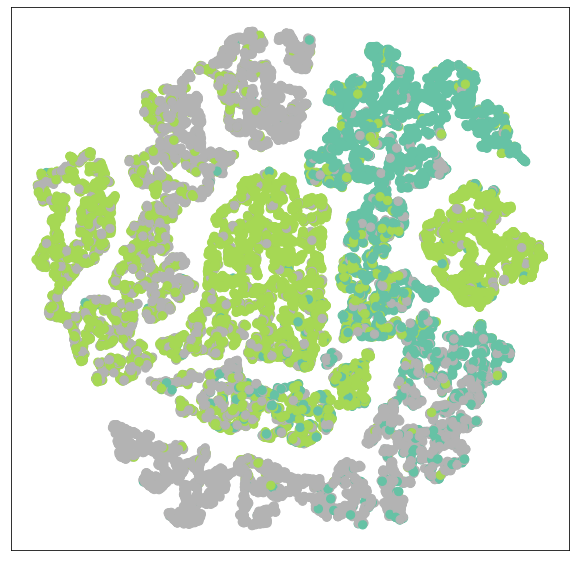

In [6]:
from torch_geometric.transforms import NormalizeFeatures

dataset = PlanetoidPubMed(root='dataset/PlanetoidPubMed/', transform=NormalizeFeatures())
print('dataset.num_features:', dataset.num_features)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)

model = GAT(num_features=dataset.num_features, hidden_channels_list=[200, 100], num_classes=dataset.num_classes).to(
    device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0: 
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

### 2.3 使用两层GCNConv神经网络进行边预测

In [7]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import train_test_split_edges
import torch_geometric.transforms as T

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = 'Cora'
path = osp.join('dataset', dataset)
# 读取Cora数据集
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]
ground_truth_edge_index = data.edge_index.to(device)
data.train_mask = data.val_mask = data.test_mask = data.y = None
# 划分数据集
data = train_test_split_edges(data)
data = data.to(device)

In [8]:
from torch_geometric.nn import GCNConv

# 构建神经网络
class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Net, self).__init__()
        self.conv1 = GCNConv(in_channels, 128)
        self.conv2 = GCNConv(128, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        return self.conv2(x, edge_index)

    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [9]:
from torch_geometric.utils import negative_sampling
import torch.nn.functional as F

# 得到边的类别{0,1}
def get_link_labels(pos_edge_index, neg_edge_index):
    num_links = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(num_links, dtype=torch.float)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels


def train(data, model, optimizer):
    model.train()
    
    # 进行负采样，使得样本数一致
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1))
    
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index)
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index).to(data.x.device)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss

In [10]:
from sklearn.metrics import roc_auc_score

@torch.no_grad()
def test(data, model):
    model.eval()

    z = model.encode(data.x, data.train_pos_edge_index)

    results = []
    for prefix in ['val', 'test']:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']
        link_logits = model.decode(z, pos_edge_index, neg_edge_index)
        # 得到正负类别概率
        link_probs = link_logits.sigmoid()
        link_labels = get_link_labels(pos_edge_index, neg_edge_index)
        results.append(roc_auc_score(link_labels.cpu(), link_probs.cpu()))
    return results

In [11]:
model = Net(dataset.num_features, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

best_val_auc = test_auc = 0
for epoch in range(1, 101):
    loss = train(data, model, optimizer)
    val_auc, tmp_test_auc = test(data, model)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        test_auc = tmp_test_auc
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
              f'Test: {test_auc:.4f}')

z = model.encode(data.x, data.train_pos_edge_index)
final_edge_index = model.decode_all(z)
print('ground truth edge shape:', ground_truth_edge_index.shape)
print('final edge shape:', final_edge_index.shape)

Epoch: 010, Loss: 0.6887, Val: 0.7162, Test: 0.7226
Epoch: 020, Loss: 0.6375, Val: 0.7589, Test: 0.7226
Epoch: 030, Loss: 0.5488, Val: 0.8073, Test: 0.7603
Epoch: 040, Loss: 0.5130, Val: 0.8434, Test: 0.8180
Epoch: 050, Loss: 0.5016, Val: 0.8496, Test: 0.8253
Epoch: 060, Loss: 0.4948, Val: 0.8609, Test: 0.8353
Epoch: 070, Loss: 0.4843, Val: 0.8752, Test: 0.8453
Epoch: 080, Loss: 0.4702, Val: 0.9039, Test: 0.8725
Epoch: 090, Loss: 0.4514, Val: 0.9201, Test: 0.8961
Epoch: 100, Loss: 0.4522, Val: 0.9264, Test: 0.9007
ground truth edge shape: torch.Size([2, 10556])
final edge shape: torch.Size([2, 3256296])
